In [6]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sns



In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 15

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory (
 "PlantVillage", shuffle = True, image_size = (IMAGE_SIZE, IMAGE_SIZE), batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset)

68

In [9]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
#     print(image_batch[0].numpy())
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 2 1 1 0 1 0 0 0 1 1 1 0 0 0 1 2 0 0 1 2 1 1 1 0 0 1 0 1 1 1]


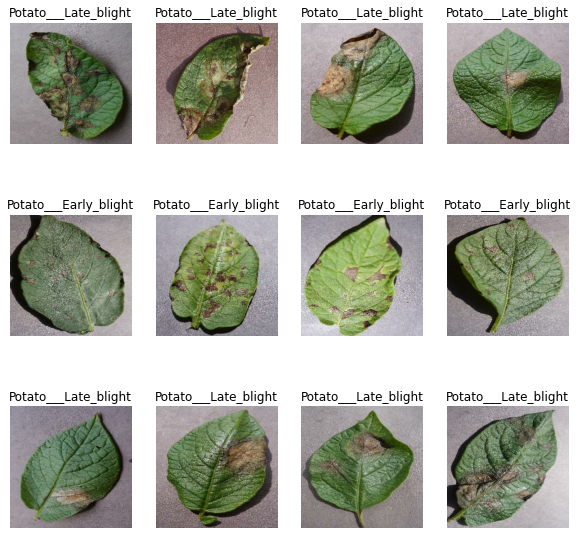

In [10]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")



In [11]:
# 80% ==> traning
# 20% ==> validation, 10% test

In [11]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [12]:
train_ds = dataset.take(54)
len(train_ds)

54

In [13]:
temp_ds = dataset.skip(54)
len(temp_ds)


14

In [14]:
val_size = 0.1
len(dataset)*val_size
val_ds = temp_ds.take(6)
len(val_ds)


6

In [15]:
test_ds = temp_ds.skip(6)
len(test_ds)

8

In [16]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1 , test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds 

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

54

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [22]:
# rollnumbers_based_CNN_model = 329531 --> 135923 , 

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

# model = models.Sequential([
#     resize_and_rescale,
#     data_augmentation,
#     layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, (3,3), activation = 'relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, (3,3), activation = 'relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, (3,3), activation = 'relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, (3,3), activation = 'relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, (3,3), activation = 'relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(n_classes, activation='softmax'),
    
# ])

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (1,1), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (5,5), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (5,5), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    
])

model.build(input_shape = input_shape)


In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      128       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                  

In [24]:
model.compile(
 optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/15
54/54 [==============================] - 45s 778ms/step - loss: 0.9041 - accuracy: 0.4722 - val_loss: 0.7594 - val_accuracy: 0.5365
Epoch 2/15
54/54 [==============================] - 43s 804ms/step - loss: 0.6065 - accuracy: 0.7083 - val_loss: 0.4408 - val_accuracy: 0.8229
Epoch 3/15
54/54 [==============================] - 43s 791ms/step - loss: 0.3780 - accuracy: 0.8438 - val_loss: 0.2460 - val_accuracy: 0.8958
Epoch 4/15
54/54 [==============================] - 43s 791ms/step - loss: 0.2385 - accuracy: 0.9034 - val_loss: 0.1916 - val_accuracy: 0.9219
Epoch 5/15
54/54 [==============================] - 43s 794ms/step - loss: 0.2322 - accuracy: 0.9057 - val_loss: 0.1337 - val_accuracy: 0.9427
Epoch 6/15
54/54 [==============================] - 42s 786ms/step - loss: 0.2225 - accuracy: 0.9115 - val_loss: 0.1211 - val_accuracy: 0.9479
Epoch 7/15
54/54 [==============================] - 43s 802ms/step - loss: 0.1695 - accuracy: 0.9416 - val_loss: 0.1219 - val_accuracy: 0.9427

In [26]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 118ms/step - loss: 0.1107 - accuracy: 0.9609


In [27]:
scores

[0.11073417216539383, 0.9609375]

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
print(loss)
print(val_loss)


[0.904083251953125, 0.6064524054527283, 0.37798142433166504, 0.23851417005062103, 0.23222234845161438, 0.22247326374053955, 0.16954641044139862, 0.15088921785354614, 0.14104631543159485, 0.13125178217887878, 0.12481115758419037, 0.1000346839427948, 0.10517608374357224, 0.08018633723258972, 0.18518826365470886]
[0.7593710422515869, 0.440757155418396, 0.24601642787456512, 0.1916191428899765, 0.13370032608509064, 0.12105247378349304, 0.12188246101140976, 0.07255563884973526, 0.1636008620262146, 0.19849978387355804, 0.055260464549064636, 0.09115716814994812, 0.168915256857872, 0.02943149209022522, 0.11730623245239258]


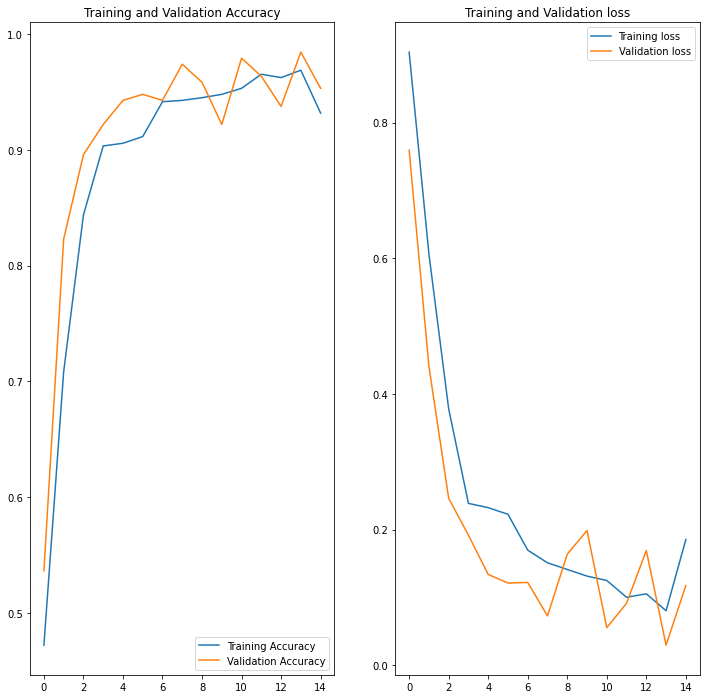

In [35]:
plt.figure(figsize = (12, 12))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')
plt.show()